In [1]:
pip install konlpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 47.8 MB/s eta 0:00:00


In [2]:
pip install gensim

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Okt
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from keras.utils import to_categorical



In [5]:
try:
    urllib.request.urlretrieve("https://raw.githubusercontent.com/tonykorea99/Spam-alart/main/dd.csv", filename='dd.csv')
    data = pd.read_csv('dd.csv', encoding='utf-8')
    data = data.sample(frac=1, random_state=42)
    print('총 샘플의 수 :', len(data))
except Exception as e:
    print('에러 발생:', e)

총 샘플의 수 : 13549


In [6]:
data[:5]

,v1,v2
811,spam,[Web발신]ifg@(광고)김영기고객님 ifg@ifg@★전북은행 이용중인 고객님께 ...
13472,ham,제가 콩국수를 싫어해서요. 어떻게 거절할까요?
12501,ham,네. 지금 시나리오 하나 쓰고 있어요 ~
8456,spam,"[국제발신]ifg@[삼성카드] **/** 고객님 해외쇼핑 ***,***원 결제완료 ..."
6415,spam,"[국제발신]ifg@[신한카드] **/** 일시불: ***,***원 (승인신청) 본인..."


In [7]:
# 레이블과 메일 내용이 담긴 v1, v2 열만 필요 : unnamed 2-4 열은 삭제
# 레이블 값을 0(ham), 1(spam)으로 변경


data['v1'] = data['v1'].replace(['ham','spam'],[0,1])
data[1199:1204]

,v1,v2
10912,1,[Web발신]ifg@(광고)박자영고객님 ifg@ifg@★전북은행 이용중인 고객님께 ...
2039,1,[Web발신]ifg@****년 고객님ifg@건강검사 통지서 발송완료.ifg@상세확인...
2753,1,[국제발신]ifg@이기석님ifg@[국민은행]ifg@***-***-*******ifg...
10050,1,[Web발신]ifg@(광고) 접수신청 안내ifg@ifg@안녕하세요 고객님 이.주.희...
530,1,[Web발신]ifg@(광고) 대상알림ifg@ifg@기분좋은 하루로 시작 하시길 바라...


In [8]:

data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 13549 entries, 811 to 7270
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      13549 non-null  int64 
 1   v2      13549 non-null  object
dtypes: int64(1), object(1)
memory usage: 317.6+ KB


In [9]:
data.isnull().values.any()

False

In [10]:
data['v2'].nunique(), data['v1'].nunique()

(13477, 2)

In [11]:
# 중복 데이터 제거

data.drop_duplicates(subset=['v2'], inplace=True)

print('총 샘플의 수 :',len(data))

총 샘플의 수 : 13477


<Axes: >

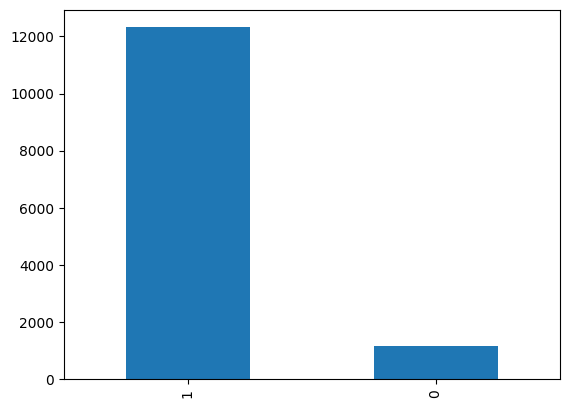

In [12]:
# 레이블 값의 분포 시각화

data['v1'].value_counts().plot(kind='bar')

In [13]:
print(data.groupby('v1').size().reset_index(name='count'))

   v1  count
0   0   1159
1   1  12318


In [15]:
okt = Okt()

# 형태소 분리 및 토크나이징
data['tokens'] = data['v2'].apply(lambda x: okt.morphs(x))

Epoch 1/5
304/304 [==============================] - 14s 25ms/step - loss: 0.3033 - accuracy: 0.9146 - val_loss: 0.3207 - val_accuracy: 0.9036
Epoch 2/5
304/304 [==============================] - 5s 15ms/step - loss: 0.2956 - accuracy: 0.9145 - val_loss: 0.3158 - val_accuracy: 0.9036
Epoch 3/5
304/304 [==============================] - 4s 12ms/step - loss: 0.2926 - accuracy: 0.9145 - val_loss: 0.3151 - val_accuracy: 0.9036
Epoch 4/5
304/304 [==============================] - 4s 15ms/step - loss: 0.2919 - accuracy: 0.9145 - val_loss: 0.3248 - val_accuracy: 0.9036
Epoch 5/5
85/85 [==============================] - 1s 7ms/step - loss: 0.2862 - accuracy: 0.9165
Accuracy: 91.65%


In [ ]:
# Doc2Vec 모델 학습을 위한 태그 설정
tagged_data = [TaggedDocument(words=_d, tags=[str(i)]) for i, _d in enumerate(data['tokens'])]

# Doc2Vec 모델 학습
model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
# 문서를 벡터로 변환
X = [model.infer_vector(doc.words) for doc in tagged_data]

In [ ]:
# 레이블 및 데이터 분리
y = data['v1'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# BiLSTM 모델 정의
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=100, output_dim=100, input_length=model.vector_size))
model_lstm.add(Bidirectional(LSTM(128)))
model_lstm.add(Dense(2, activation='softmax'))

# 모델 컴파일
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# 문서 벡터에 패딩 추가
X_train_pad = pad_sequences(X_train)
X_test_pad = pad_sequences(X_test)


In [ ]:
# 레이블 원핫인코딩
y_train_onehot = to_categorical(y_train, num_classes=2)
y_test_onehot = to_categorical(y_test, num_classes=2)


In [ ]:
# 모델 훈련
model_lstm.fit(X_train_pad, y_train_onehot, epochs=5, batch_size=32, validation_split=0.1)


In [ ]:
# 모델 평가
loss, accuracy = model_lstm.evaluate(X_test_pad, y_test_onehot)
print(f'Accuracy: {accuracy * 100:.2f}%')